### Churn Detection

1. Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap

2. Import Dataset

In [2]:
df_train = pd.read_csv('train.csv')

In [3]:
df_train.Exited.value_counts(normalize=True)

Exited
0    0.788401
1    0.211599
Name: proportion, dtype: float64

In [4]:
## drop useless columns
useless = ['Surname', 'CustomerId', 'id']
df_train.drop(useless, axis=1, inplace=True)

## Feature engineering

In [5]:
### Encoding categorial features

# encoder gender feature
df_train['Gender']=df_train['Gender'].map({'Male':0,'Female':1})

# apply one-hot encoding to the 'category' column
one_hot_encoded = pd.get_dummies(df_train['Geography'])

# join the one-hot encoded columns to the original dataframe
df_train = df_train.join(one_hot_encoded)

# drop the original 'category' column
df_train = df_train.drop('Geography', axis=1)

df_train.drop('Spain', axis=1, inplace=True)

## Train and Test split

In [12]:
X = df_train.drop('Exited', axis=1)
y = df_train['Exited']

In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.20)

## Modelisation 

In [26]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

* Xgboost 

In [27]:
## train a base xgboost classifier
xgb_base = XGBClassifier()
xgb_base.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [33]:
# Make predictions and evaluate the model using AUC
preds_xgb_base = xgb_base.predict_proba(X_test)[:, 1]
auc_xgb_base = roc_auc_score(y_test, preds_xgb_base)

In [34]:
auc_xgb_base

0.88831726581676

* Xgboost with hyper parameters tunning

In [15]:
# Create XGBoost classifier
xgb_model = XGBClassifier()

# Define a grid of hyperparameters to search over
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

In [16]:
# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 1, 5],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc', verbose=1)

In [32]:
## best parameters
parameters = grid_search.best_params_
# initialise model with parameters
xgb_tuned = XGBClassifier(**parameters)
xgb_tuned.fit(X_train, y_train)
preds_xgb_tuned = xgb_tuned.predict_proba(X_test)[:, 1]
auc_xgb_tuned = roc_auc_score(y_test, preds_xgb_tuned)
auc_xgb_tuned

0.8915329408649383

In [ ]:
all_predictions = {
    "XGBoost_base_model" : preds_xgb_base,
    "XGBoost_tuned" : preds_xgb_tuned
}

In [ ]:
plt.figure(figsize=(18, 14))
for x in all_predictions:
    label, prediction = x['label'], x['prediction']
    fpr, tpr, thresholds = roc_curve(y_val, prediction)
    auc = roc_auc_score(y_val, prediction) * 100
    plt.plot(fpr, tpr, label="{} : {:.2f}".format(label, auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Test set (201703) ROC Curves - All iterations')
plt.legend(loc="lower right", title="AUC score")
plt.show()

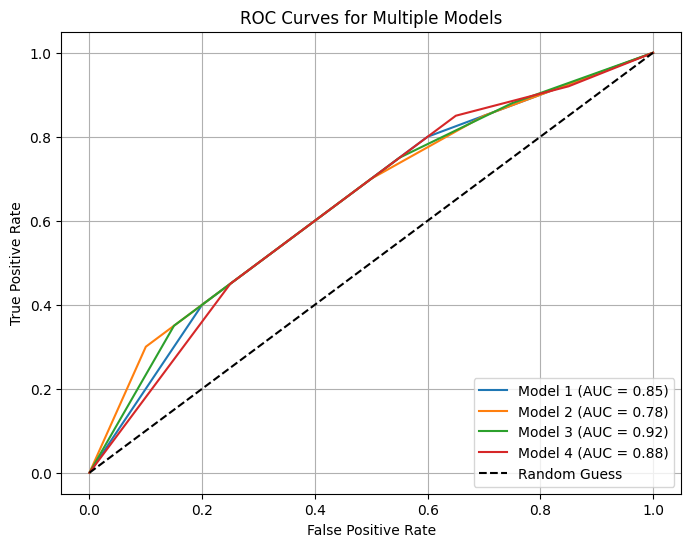

In [23]:
import matplotlib.pyplot as plt

# Plot the ROC curves for each model
plt.figure(figsize=(8, 6))


plt.plot(fpr_model1, tpr_model1, label=f'Model 1 (AUC = {auc_model1:.2f})')
plt.plot(fpr_model2, tpr_model2, label=f'Model 2 (AUC = {auc_model2:.2f})')
plt.plot(fpr_model3, tpr_model3, label=f'Model 3 (AUC = {auc_model3:.2f})')
plt.plot(fpr_model4, tpr_model4, label=f'Model 4 (AUC = {auc_model4:.2f})')

# Plot a diagonal line representing random guess
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiple Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
